# Imports

You may need to install the packages in the requirements.txt file. This does not require a GPU, so if you are using colab, you can select the "Runtime" -> "Change runtime type" menu and select "None" as the hardware accelerator.

** Note** The same variables get defined in different ways in different subparts. If you get an error saying that a variable is the wrong shape or a function is missing an argument, make sure you have re-run the cells in that problem subpart.

In [1]:
# Import numpy and torch
import numpy as np
import torch
import torch.nn as nn
import math
import random
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]  # Adjust this to make plots bigger or smaller


# Learning Goals:

* Implement a simple transformer model from scratch so you can understand how it works.
* Hand-design a transformer model to solve a simple task so you can understand the kinds of operations which a transformer can perform.
* Visualize the attention patterns of a learned network to see how learned models often use very different features from humans.

# (A): Implementing a Very Simple Transformer

We've already provided a simple transformer implementation in numpy in the cell below. There are a lot of common features of transformers which are not included here! You'll implement a more realistic transformer on HW 7.

* The transformer is only a single layer and a single head.
* There are no residual connections.
* There is no normalization or dropout.
* We concatenate the positional encoding rather than adding it to the inputs.
* There are no activation functions or MLP layers.
* The transformer does not support masking or batching.

To check your understanding, implement a PyTorch equivalent model. You don't need to include the printing and plotting code in the Numpy version. Consider implementing a batched version of the attention operation - i.e. calculate all attention scores at once, not by looping over keys. (This is not required, but it should run faster and will help you understand the attention mechanism better since you can't directly translate it from the Numpy version.) Make sure your implementation passes the tests in the cell below.

### Helper functions (you don't need to modify these or understand them in depth)

In [2]:
def rescale_and_plot(arr, title='', ax=None, x_lab=None, y_lab=None):
    """Rescale input array to be between 0 and 1, then plot it"""
    arr = (arr - arr.min())
    if arr.max() > 0:
        arr = arr / arr.max()
    ax.imshow(arr)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if x_lab is not None:
        ax.set_xlabel(x_lab)
    if y_lab is not None:
        ax.set_ylabel(y_lab)


def train_loop(make_batch, input_dim, qk_dim, v_dim, pos_dim=None, max_seq_len=None, remove_cls=False, num_epochs=10001, lr=3e-2):
    transformer = PytorchTransformer(input_dim, qk_dim, v_dim, pos_dim, max_seq_len)
    optimizer = torch.optim.SGD(transformer.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for i in range(num_epochs):
        seq, target = make_batch()
        optimizer.zero_grad()
        out = transformer(seq)
        # If remove_cls is True, remove the first item of the sequence (the CLS token)
        if remove_cls:
            out = out[1:]
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print(f'Step {i}: loss {loss.item()}')
    return transformer, loss.item()

def compare_transformers(hand_transformer, learned_transformer, seq):
    # Print the learned matrices
    # Rescale each weight matrix to be between 0 and 1, then plot them
    print('=' * 40, ' Hand Designed ', '=' * 40)
    out_hand = hand_transformer.forward(seq, verbose=False, plot=True)
    
    # Copy weights from the learned transformer to the hand transformer
    # so we can run the hand transformer's forward pass, with the plotting code
    py_Km = learned_transformer.Km.weight.T.detach().numpy()
    py_Qm = learned_transformer.Qm.weight.T.detach().numpy()
    py_Vm = learned_transformer.Vm.weight.T.detach().numpy()
    # positional encodings, if they exist
    if learned_transformer.pos is not None:
        py_pos = learned_transformer.pos.weight.detach().numpy()
    else:
        py_pos = None

    print('=' * 40, '   Learned   ', '=' * 40)
    np_learned_transformer = NumpyTransformer(py_Km, py_Qm, py_Vm, py_pos)
    out_learned = np_learned_transformer.forward(seq, verbose=False, plot=True)
    return out_hand, out_learned

# Test the numpy transformer and pytorch transformer to make sure they give the same results
def test():
    min_seq_len = 1
    max_seq_len = 4
    qk_dim = np.random.randint(1, 5)
    v_dim = np.random.randint(1, 5)
    in_dim = 5
    for i in range(10):
        # Randomly sample the matrices
        Km = np.random.randn(in_dim, qk_dim)
        Qm = np.random.randn(in_dim, qk_dim)
        Vm = np.random.randn(in_dim, v_dim)
        if i > 4:
            # Sometimes, don't use positional encodings
            pos = pos_dim = None
            seq_dim = in_dim
        else:
            pos_dim = np.random.randint(2, 4)
            pos = np.random.randn(max_seq_len, pos_dim)
            seq_dim = in_dim - pos_dim
            
        # Randomly sample the sequence
        seq = np.random.randn(np.random.randint(min_seq_len, max_seq_len + 1), seq_dim)
        # Get the numpy transformer output
        out_np = NumpyTransformer(Km, Qm, Vm, pos).forward(seq, verbose=False)
        # Create a pytorch transformer and fill the weights with the numpy matrices
        transformer = PytorchTransformer(seq_dim, qk_dim, v_dim, pos_dim, max_seq_len)
        state_dict = transformer.state_dict()
        # Replace the weights with the numpy matrices
        state_dict['Km.weight'] = torch.FloatTensor(Km.T)
        state_dict['Qm.weight'] = torch.FloatTensor(Qm.T)
        state_dict['Vm.weight'] = torch.FloatTensor(Vm.T)
        if pos is not None:
            state_dict['pos.weight'] = torch.FloatTensor(pos)
        transformer.load_state_dict(state_dict)
        # Get the pytorch transformer output
        out_py = transformer(torch.FloatTensor(seq)).detach().numpy()
        # Compare the outputs
        if not np.allclose(out_np, out_py, atol=1e-5):
            print('ERROR!!')
            print('Numpy output', out_np)
            print('Pytorch output', out_py)
            print('Difference', out_np - out_py)
            raise ValueError('Numpy and Pytorch outputs do not match')
    print('All done!')

### Transformer class (you need to implement this)

In [3]:
class NumpyTransformer:
    def __init__(self, Km, Qm, Vm, pos=None):
        """
        # Km, Qm, Vm are the matrices that will be used to compute the attention
        # Km and Qm are size (input_dim + pos_dim, qk_dim), and Vm is (input_dim + pos_dim, v_dim).
        # pos is an array of positional encodings of shape (max_seq_len, pos_dim) that will be concatenated to the input sequence
        """
        self.Km = Km
        self.Qm = Qm
        self.Vm = Vm
        self.pos = pos
        self.qk_dim = Qm.shape[1]
        
    def forward(self, seq, verbose=False, plot=False):
        # seq is a numpy array of shape (seq_len, input_dim). There is no batch dimension.
        
        # Concatenate positional encodings if they are provided
        # print('org seq is', seq.shape)
        if self.pos is not None:
            seq = np.concatenate([seq, self.pos[:seq.shape[0]]], axis=-1)
        # print('seq is', seq.shape)
        # print("k is ", self.Km.shape)
        # print('Q is', self.Qm.shape)
        # print('V is', self.Vm.shape)
        K = seq @ self.Km # seq_len x qk_dim
        Q = seq @ self.Qm # seq_len x qk_dim
        V = seq @ self.Vm # seq_len x v_dim

        if verbose:
            print('Keys', K.tolist())
            print('Queries', Q.tolist())
            print('Values', V.tolist())
        if plot:
            fig, axs = plt.subplots(nrows=1,ncols=8)
            fig.tight_layout()
            rescale_and_plot(self.Km.T, 'Km', axs[0], x_lab='d_i', y_lab='d_qk')
            rescale_and_plot(self.Qm.T, 'Qm', axs[1], x_lab='d_i', y_lab='d_qk')
            rescale_and_plot(self.Vm.T, 'Vm', axs[2], x_lab='d_i', y_lab='d_v')
            
            rescale_and_plot(K.T, 'K', axs[3], x_lab='seq', y_lab='d_qk')
            rescale_and_plot(Q.T, 'Q', axs[4], x_lab='seq', y_lab='d_qk')
            rescale_and_plot(V.T, 'V', axs[5], x_lab='seq', y_lab='d_v')
            
        outputs = []
        attn_weights = []
        # Compute attention
        for i, q in enumerate(Q):
            if verbose: print(f'Item {i}: Computing attention for query {q}')
            dot = K @ q
            if verbose: print('  Dot products between the query and each key:', dot)
            # Divide by sqrt(qk_dim)
            dot = dot / np.sqrt(self.qk_dim)
            # Softmax function
            softmax_dot = np.exp(dot) / np.sum(np.exp(dot), axis=-1, keepdims=True)
            if verbose: print('  Weighting score for each value:', softmax_dot)
            attn_weights.append(softmax_dot)
            out_i = softmax_dot @ V
            if verbose: print('  New sequence item', out_i)
            outputs.append(out_i)
        if plot:
            rescale_and_plot(np.array(attn_weights).T, 'Attn', axs[6], x_lab='Q', y_lab='K')
            rescale_and_plot(np.array(outputs).T, 'Out', axs[7], x_lab='seq', y_lab='d_v')
            plt.show()
            
        # Return the output sequence (seq_len, output_dim)
        return np.array(outputs)
    
class PytorchTransformer(nn.Module):
    def __init__(self, input_dim, qk_dim, v_dim, pos_dim=None, max_seq_len=10):
        super().__init__()
        if pos_dim is not None:
            self.pos = nn.Embedding(max_seq_len, pos_dim)
        else:
            self.pos = None
        in_dim = input_dim
        if pos_dim is not None:
            in_dim += pos_dim
        self.Km = nn.Linear(in_dim, qk_dim, bias=False)
        self.Qm = nn.Linear(in_dim, qk_dim, bias=False)
        self.Vm = nn.Linear(in_dim, v_dim, bias=False)
        self.in_dim = in_dim
        self.d_k = qk_dim
        self.out_dim = v_dim
        
    def forward(self, seq):
        # seq is a numpy array of shape (seq_len, input_dim). There is no batch dimension.
        # print(len(seq.shape))
        if len(seq.shape) > 2:
            seq = torch.squeeze(seq)
        if len(seq.shape) < 2:
            seq = seq[None]
        # print(seq)
        # seq = torch.LongTensor(se)
        # Concatenate positional encodings if they are provided
        
        if self.pos is not None:
            seq = torch.cat([seq, self.pos.weight[:seq.shape[0]]], axis=-1)
        # assert seq_len == self.in_dim
        # (seq_len, input_dim) = seq.shape
        K = self.Km(seq) # seq_len x qk_dim
        Q = self.Qm(seq) # seq_len x qk_dim
        V = self.Vm(seq) # seq_len x v_dim
        # print('K is', K.shape)
        # print('Q is', Q.shape)
        # print('V is', V.shape)
        # print('seq is', seq.shape)
        # print('seq_len is', seq.shape[0])
        # print('qk_dim is', self.d_k)
        # print('v dim is', self.out_dim)
        # print(seq)
        # assert K.shape == (seq.shape[0], self.d_k)
        # assert Q.shape == (seq.shape[0], self.d_k)
        outputs = torch.zeros((seq.shape[0], self.out_dim))
        attn_weights = []
        # Compute attention
        for i, q in enumerate(Q):
            dot = K @ q
            # if verbose: print('  Dot products between the query and each key:', dot)
            # Divide by sqrt(qk_dim)
            dot = dot / np.sqrt(self.d_k)
            # Softmax function
            softmax_dot = torch.exp(dot) / torch.sum(torch.exp(dot), axis=-1, keepdims=True)
            # if verbose: print('  Weighting score for each value:', softmax_dot)
            attn_weights.append(softmax_dot)
            out_i = softmax_dot @ V
            # if verbose: print('  New sequence item', out_i)
            outputs[i] = out_i
        # Return the output sequence (seq_len, output_dim)
        return outputs
    
test()    

All done!


# (B) Self-Attention Operation: Attending by Content

Transformers can decide what other tokens to attend to by looking at the content of the tokens. In this section, we'll explore how this works by hand-implementing a transformer which gets applied to a variable-length sequence in which each token is a one-hot vector.

The function we will learn is the identity operation (i.e. the output is the same as the input). Choose values for Km, Qm, and Vm to implement this.

\# Example data points (in each case, A, B, and C are vectors): \
Input sequence --> Output sequence \
[A, B, C, C] --> [A, B, C, C] \
[C, A, C] --> [C, A, C] \
[B, B, C] --> [B, B, C]


Once the test cases pass, run the training loop below a few times to train the PyTorch model. Comment on the similarities and differences between the weights and intermediate outputs of the learned and hand-coded model. (Note: the plotting function rescales the range to 0, 1. It's fine to compare the relative values of weights/outputs between the two models (e.g. say "both attend most strongly to X"), without comparing the absolute values.)

In [4]:
# Hints (feel free to ignore this block if it's not useful)

# Hint 1: If you want to attend to one particular element, make sure its pre-softmax score is much larger than the other elements. 
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)
print('='*20, 'Hint 1', '='*20)
print('Selecting index 0', softmax(np.array([9, 0, 0])))
print('Selecting index 1', softmax(np.array([-3, 5, -5])))

# Hint 2: It's easier to attend to a particular element if the keys are orthogonal.
print('='*20, 'Hint 2', '='*20)
keys = np.array([[2, 0], [0, 1]])  # Orthogonal
q = np.array([5, 0])
print('Selecting index 0', softmax(q @ keys))
q = np.array([0, 5])
print('Selecting index 1', softmax(q @ keys))

# Hint 3: You can use the following helper functions to test what keys, queries, and values would be produced by your matrix for each valid sequence element.
#  Km, Qm, Vm, and are the matrices you will define below.
all_token_seq = np.eye(3)  # Each row is a sequence element. The identity corresponds to [A, B, C].
get_K = lambda Km: all_token_seq @ Km # Each row of the output is a key
get_Q = lambda Qm: all_token_seq @ Qm # Each row of the output is a query
get_V = lambda Vm: all_token_seq @ Vm # Each row of the output is a value

# Hint 4: Use the softmax function defined above to test what softmax scores you'd get for different attention weights.

# Hint 5: If there are repeated elements in a sequence with the same content, rather than attenting to one particular element, it will be easier to
# attend to all of them. Since they have the same content, when you take a "weighted average" over values weighted by attention scores you'll get the
# same output as you'd get if you attended to a single one.


==================== Hint 1 ====================
Selecting index 0 [9.99753241e-01 1.23379352e-04 1.23379352e-04]
Selecting index 1 [3.35334911e-04 9.99619282e-01 4.53826452e-05]
==================== Hint 2 ====================
Selecting index 0 [9.99954602e-01 4.53978687e-05]
Selecting index 1 [0.00669285 0.99330715]


In [5]:

# Tokens
A = np.array([1,0,0])
B = np.array([0,1,0])
C = np.array([0,0,1])
tokens = [A, B, C]

################################################################################################
# TODO: Implement numpy arrays for Km, Qm, and Vm.
#      The dimensions should be (input_dim, qk_dim), (input_dim, qk_dim), and (input_dim, v_dim)
#      In this case, input_dim = 3, and v_dim = 3. qk_dim can be any value you choose, but 3 is
#      a reasonable choice.
#################################################################################################
Km = np.array([[9.,0.,0.],[0.,9.,0.],[0.,0.,9.]])
Qm = np.array([[9.,0.,0.],[0.,9.,0.],[0.,0.,9.]])
Vm = np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])
print(Km, Qm, Vm)
############################################ END OF YOUR CODE ####################################
Km, Qm, Vm = get_K(Km), get_Q(Qm), get_V(Vm)
def generate_test_cases_identity(tokens, max_len=7):
    seq_len = np.random.randint(1, max_len)
    input_arr = np.stack(random.choices(tokens, k=seq_len))
    expected_out = input_arr
    return input_arr, expected_out

# Test your implementation
for i in range(10):
    seq, expected_out = generate_test_cases_identity(tokens)
    np_transformer = NumpyTransformer(Km, Qm, Vm)
    out = np_transformer.forward(seq, verbose=False)  # Change this to True to see the attention computation
    if not np.allclose(out, expected_out, atol=.1):
        print(f'FAIL: {seq} -> {out} != {expected_out}')


[[9. 0. 0.]
 [0. 9. 0.]
 [0. 0. 9.]] [[9. 0. 0.]
 [0. 9. 0.]
 [0. 0. 9.]] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


Step 0: loss 0.4139789342880249


/home/cleverctz/anaconda3/envs/deepl/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 4, 3])) that is different to the input size (torch.Size([4, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/cleverctz/anaconda3/envs/deepl/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 3, 3])) that is different to the input size (torch.Size([3, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/cleverctz/anaconda3/envs/deepl/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 2, 3])) that is different to the input size (torch.Size([2, 3])). This will likely lead to incorrect results

Step 1000: loss 0.14446578919887543
Step 2000: loss 0.11750143021345139
Step 3000: loss 0.047645602375268936
Step 4000: loss 0.0020077864173799753
Step 5000: loss 0.0021083864849060774
Step 6000: loss 0.00406732177361846
Step 7000: loss 0.003444056259468198
Step 8000: loss 0.0010435545118525624
Step 9000: loss 0.0006379818660207093
Step 10000: loss 0.00023271789541468024
========================================  Hand Designed  ========================================


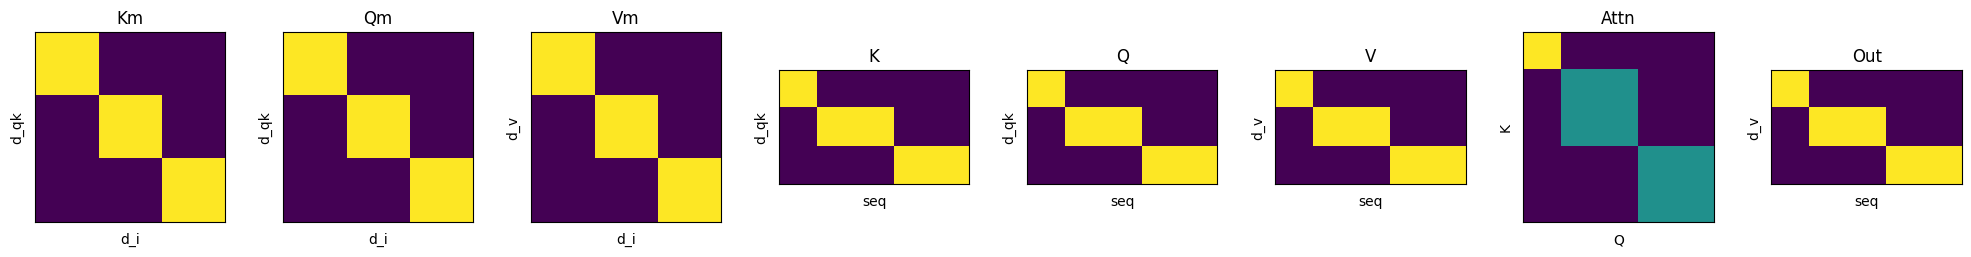

========================================    Learned    ========================================


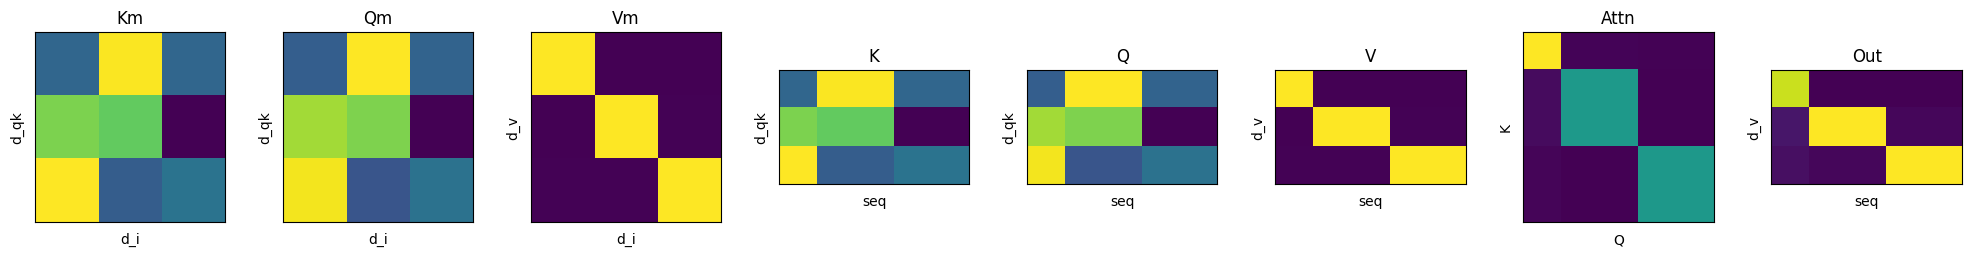

(array([[1.00000000e+00, 9.79686395e-21, 9.79686395e-21],
        [2.44921599e-21, 1.00000000e+00, 4.89843197e-21],
        [2.44921599e-21, 1.00000000e+00, 4.89843197e-21],
        [2.44921599e-21, 4.89843197e-21, 1.00000000e+00],
        [2.44921599e-21, 4.89843197e-21, 1.00000000e+00]]),
 array([[ 0.90659596,  0.05680395,  0.03659973],
        [-0.00121689,  0.98756306,  0.01365381],
        [-0.00121689,  0.98756306,  0.01365381],
        [-0.00225375,  0.01691063,  0.98534347],
        [-0.00225375,  0.01691063,  0.98534347]]))

In [6]:
# Compare the hand-designed and trained transformers
def make_batch_identity(tokens=tokens, max_len=7):
    seq, target = generate_test_cases_identity(tokens, max_len=max_len)
    return torch.FloatTensor(seq).unsqueeze(0), torch.FloatTensor(target).unsqueeze(0)

A = np.array([1,0,0])
B = np.array([0,1,0])
C = np.array([0,0,1])

transformer_py, loss = train_loop(make_batch_identity, input_dim=len(A), qk_dim=Km.shape[1], v_dim=Vm.shape[1])
seq = np.stack([A, B, B, C, C])
seq.squeeze()
compare_transformers(np_transformer, transformer_py, seq)  # If the plots don't print correctly, re-run this cell

# (C) Self-Attention Operation: Attending by Position

Transformers can decide what other tokens to attend to by looking at the positions of the tokens. In this section, we'll explore how this works by designing a transformer for the following task: given a sequence of tokens, copy the first token across the entire sequence.

To do this, we'll add a positional encoding to the input sequence. Transformers typically use a sinusoidal positional encoding or a learned positional encoding. We'll use a 'learned' positional encoding (though in this case we are setting the weights by hand, so you can set the weight to whatever you want).

These positional encodings will get concatenated to the input sequence inside the transformer.

\# Example data points (in each case, A, B, and C are vectors. A:pos_0 represents concatenation between vectors A and pos_0): \
Input sequence --> Input sequence with pos encoding --> Output sequence \
[A, B, C, C] --> [A:pos_0, B:pos_1, C:pos_2, C:pos_3] --> [A, A, A, A] \
[C, A, C] --> [C:pos_0, A:pos_1, C:pos_2] --> [C, C, C] \
[B, B, C] --> [B:pos_0, B:pos_1, C:pos_2] --> [B, B, B]

Typically, these positional encodings are added to the input embeddings. In this case, for simplicity we'll concatenate the positional encoding to the input embeddings instead.

Once the test cases pass, run the training loop below a few times to train the PyTorch model. Comment on the similarities and differences between the weights and intermediate outputs of the learned and hand-coded model.

In [7]:
# Hints (feel free to ignore this block if it's not useful) 

# Hint 1: All hints from the previous part still apply.

# Hint 2: If you only want to use part of the information in a sequence element, choose key/query/value matrices which remove the unwanted information.
seq = np.array([[1, 2, 3]]) # A sequence of length 1 with a 3-dimensional element
Qm = np.array([[1, 0], [0, 0], [0, 1]])
print('Selecting only the first and last vector elements', seq @ Qm)

# Hint 3: You can use the following helper functions to test what keys, queries, and values would be produced by your matrix.
# You will need to provide a sequence (e.g. np.stack([A, B, C])). Km, Qm, Vm, and pos are the matrices you will define below.
get_K = lambda seq: np.concatenate([seq, pos[:seq.shape[0]]], axis=1) @ Km # Each row of the output is a key
get_Q = lambda seq: np.concatenate([seq, pos[:seq.shape[0]]], axis=1) @ Qm # Each row of the output is a query
get_V = lambda seq: np.concatenate([seq, pos[:seq.shape[0]]], axis=1) @ Vm # Each row of the output is a value


Selecting only the first and last vector elements [[1 3]]


In [46]:
A = np.array([1,0,0])
B = np.array([0,1,0])
C = np.array([0,0,1])

tokens = [A, B, C]

################################################################################################
# TODO: Implement numpy arrays for Km, Qm, and Vm and pos.
#      The dimensions of Km, and Qm are (input_dim + pos_dim, qk_dim).
#      The dimensions of Vm are (input_dim + pos_dim, v_dim).
#      The dimensions of pos are (max_len, pos_dim). (Each row is a position vector.)
#      In this case, input_dim = 3, and v_dim = 3. qk_dim can be any value you choose, but 1 is
#      a reasonable choice. max_len is the maximum sequence length you will encounter, 4 in this case.
#      pos_dim can be any value you choose, but 4 is a resonable choice.
#################################################################################################

pos = np.array([[1, .05, -.025, -.025], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
Km = np.array([[9],[9],[9],[9],[9],[9],[9]])
Qm = np.array([[6],[6],[6],[6],[6],[6],[6]])
Vm = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1],[0, 0, 0],[1, 0, 1],[1, 1, 0],[0, 1, 1]])
############################################ END OF YOUR CODE ####################################


def generate_test_cases_first(tokens, max_len=5):
    seq_len = np.random.randint(1, max_len)
    input_arr = np.stack(random.choices(tokens, k=seq_len))
    # Expected output is to repeat the first row of the input k times
    expected_out = np.stack([input_arr[0]] * seq_len)
    return input_arr, expected_out


for i in range(10):
    seq, expected_out = generate_test_cases_first([A, B, C])
    np_transformer = NumpyTransformer(Km, Qm, Vm, pos=pos)
    out = np_transformer.forward(seq, verbose=False)  # Change this to True to see the attention computation
    if not np.allclose(out, expected_out, atol=.1):
        print(f'FAIL: {seq} -> {out} != {expected_out}')



Step 0: loss 0.30754220485687256
Step 1000: loss 0.07036926597356796
Step 2000: loss 0.07233837991952896
Step 3000: loss 0.002502183662727475
Step 4000: loss 0.00017987494356930256
Step 5000: loss 0.00010358672443544492
Step 6000: loss 0.0007520006620325148
Step 7000: loss 0.00012486378545872867
Step 8000: loss 0.00015035113028716296
Step 9000: loss 2.749625673459377e-05
Step 10000: loss 6.927669164724648e-05
========================================  Hand Designed  ========================================


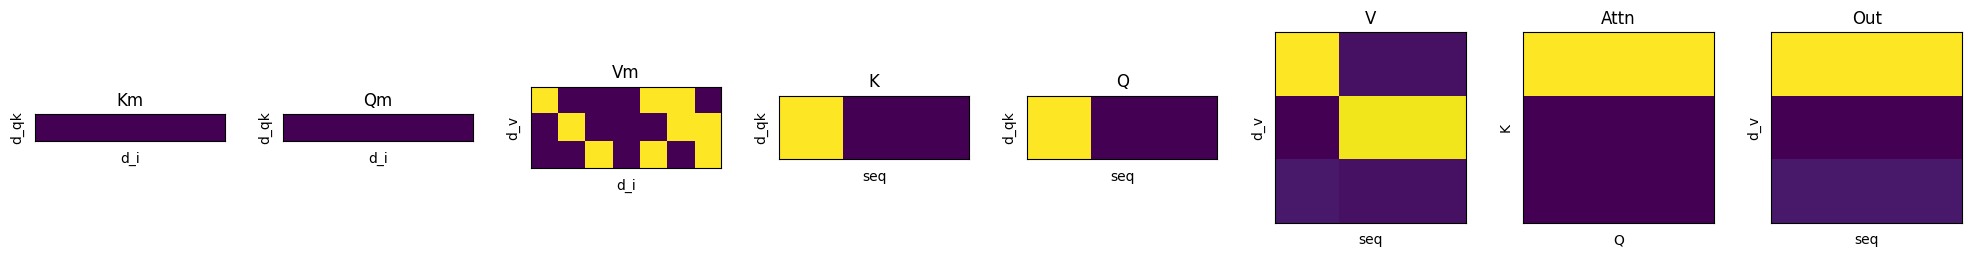

========================================    Learned    ========================================


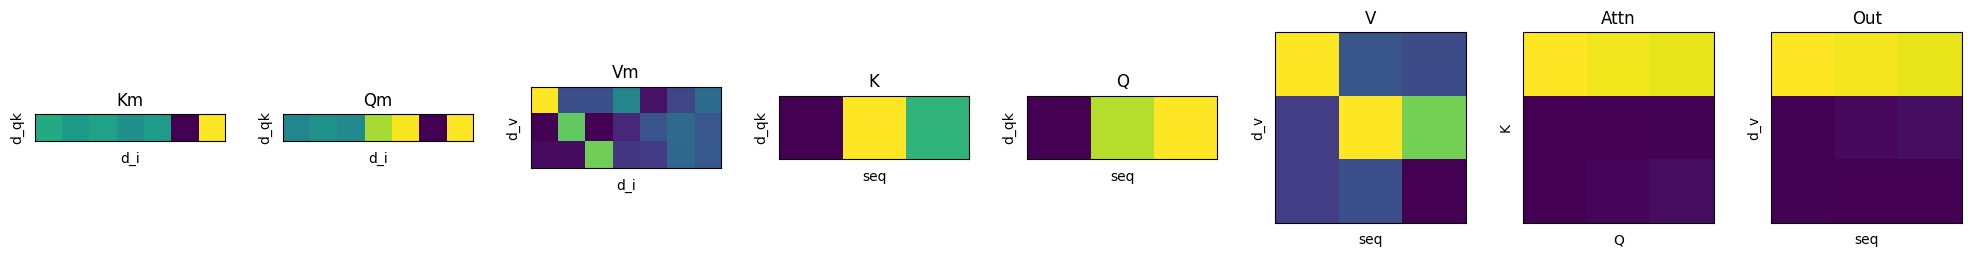

Out (Hand designed) 
 [[ 1.03 -0.05  0.02]
 [ 1.03 -0.05  0.02]
 [ 1.03 -0.05  0.02]]
 Out (Learned) 
 [[ 1.   -0.   -0.  ]
 [ 0.98  0.02 -0.  ]
 [ 0.97  0.03 -0.01]]


In [47]:
# Compare the numpy and trained pytorch transformers
def make_batch_first(tokens=tokens, max_len=5):
    seq, target = generate_test_cases_first(tokens, max_len=max_len)
    return torch.FloatTensor(seq), torch.FloatTensor(target)

pos_dim = pos.shape[1]
transformer_py, loss = train_loop(make_batch_first, input_dim=len(A), qk_dim=Km.shape[1], v_dim=Vm.shape[1], pos_dim=pos_dim, max_seq_len=pos.shape[0])
seq = np.stack([A, B, B])
out_np, out_py = compare_transformers(np_transformer, transformer_py, seq)
print(f'Out (Hand designed) \n {np.round(out_np, 2)}')
print(f' Out (Learned) \n {np.round(out_py, 2)}')

# [Optional] (D) Self-Attention Operation: Selecting by Position and Content

Finally, we'll explore how transformers can attend to tokens by looking at both their position and their content. In this section, we'll design a transformer for the following task: given a sequence of tokens, output a positive number for every unique token and a negative number for every repeated token.

To make implementing this easier, we'll add a CLS token to the beginning of the sequence. We will ignore the output of the CLS token index, which means we can use the CLS token to represent whatever we want. (In practice, the CLS token is often thought of as a representation of the entire sequence, but you can use it however is useful.)


\# Example data points (in each case, A, B, and C are vectors. A:pos_0 represents concatenation between vectors A and pos_0. The target outputs shown are +/-1, but any number with the right sign is fine. "Ignore" means that the output can be anything and will not be used to compute the loss.): \
Input sequence --> Input sequence with CLS and pos encoding --> Output sequence \
[A, B, C, C] --> [CLS: pos_0, A:pos_1, B:pos_2, C:pos_3, C:pos_4] --> [Ignore, 1, 1, -1, -1] \
[C, A, C] --> [CLS: pos_0, C:pos_1, A:pos_2, C:pos_3] --> [Ignore, -1, 1, 1] \
[B, B, C] --> [CLS: pos_0, B:pos_1, B:pos_2, C:pos_3] --> [Ignore, -1, -1, 1]


Once the test cases pass, run the training loop below a few times to train the PyTorch model. Comment on the similarities and differences between the weights and intermediate outputs of the learned and hand-coded model.

In [10]:
A = np.array([1,0,0,0])
B = np.array([0,1,0,0])
C = np.array([0,0,1,0])
CLS = np.array([0,0,0,1])

tokens = [A, B, C]

In [11]:
# Hints (feel free to ignore this block if it's not useful) 

# Hint 1: All hints from the previous part still apply.

# Hint 2: To check if an array is unique, use what you discovered in the "select by content" part to find rows with the same value and 
# what you learned in the "select by position" part to NOT select the key which comes from the same position as the query.

# Hint 3: If you need an offset value, consider using the CLS token The CLS token is the first token in a sequence, and it is orthogonal
# to all other tokens. This means you can create a query or value which selects it but not any othe token (e.g. by putting 0s in all 
# indexes except the index where only CLS has a 1).

# Hint 4: You can use the following helper functions to test what keys, queries, and values would be produced by your matrix.
# You will need to provide a sequence (e.g. np.stack([A, B, C])). Km, Qm, Vm, and pos are the matrices you will define below.
get_K = lambda seq: np.concatenate([np.stack([CLS] + list(seq)), pos[:seq.shape[0]+1]], axis=1) @ Km # Each row of the output is a key
get_Q = lambda seq: np.concatenate([np.stack([CLS] + list(seq)), pos[:seq.shape[0]+1]], axis=1) @ Qm # Each row of the output is a query
get_V = lambda seq: np.concatenate([np.stack([CLS] + list(seq)), pos[:seq.shape[0]+1]], axis=1) @ Vm # Each row of the output is a value


In [12]:

################################################################################################
# TODO: Implement numpy arrays for Km, Qm, and Vm and pos.
#      The dimensions of Km, and Qm are (input_dim + pos_dim, qk_dim).
#      The dimensions of Vm are (input_dim + pos_dim, v_dim).
#      The dimensions of pos are (max_len + 1, pos_dim). (Each row is a position vector.)
#      In this case, input_dim = 4, and v_dim = 1. qk_dim can be any value you choose, but 8 is
#      a reasonable choice. max_len is the maximum sequence length you will encounter (before CLS is added),
#      4 in this case.  pos_dim can be any value you choose, but 4 is a reasonable choice.
#################################################################################################

############################################ END OF YOUR CODE ####################################

def generate_test_cases_unique(tokens, max_len=5):
    seq_len = np.random.randint(1, max_len)
    input_arr = np.stack(random.choices(tokens, k=seq_len))
    # Expected output is 1 for unique, -1 for non-unique
    expected_out = np.stack([1 if np.sum(np.min(input_arr == x, axis=1)) == 1 else -1 for x in input_arr]).reshape(-1, 1)
    # Insert CLS token as the first token in the sequence
    input_arr = np.stack([CLS] + list(input_arr))
    return input_arr, expected_out

seq, expected_out = generate_test_cases_unique([A, B, C])

for i in range(1):
    seq, expected_out = generate_test_cases_unique([A, B, C])
    np_transformer = NumpyTransformer(Km, Qm, Vm, pos)
    out = np_transformer.forward(seq, verbose=False)  # Change this to True to see the attention computation
    if not np.allclose(np.sign(out[1:]), expected_out, atol=.1):
        print(f'FAIL: {seq} -> {np.sign(out[1:])} != {expected_out}')


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 7 is different from 8)

Step 0: loss 1.306623101234436
Step 1000: loss 1.0388542413711548
Step 2000: loss 0.45778796076774597
Step 3000: loss 0.40186887979507446
Step 4000: loss 0.1301518678665161
Step 5000: loss 0.15481506288051605
Step 6000: loss 0.038022950291633606
Step 7000: loss 0.0024105096235871315
Step 8000: loss 0.006559297442436218
Step 9000: loss 0.01687362603843212
Step 10000: loss 0.002265977207571268
========================================  Hand Designed  ========================================


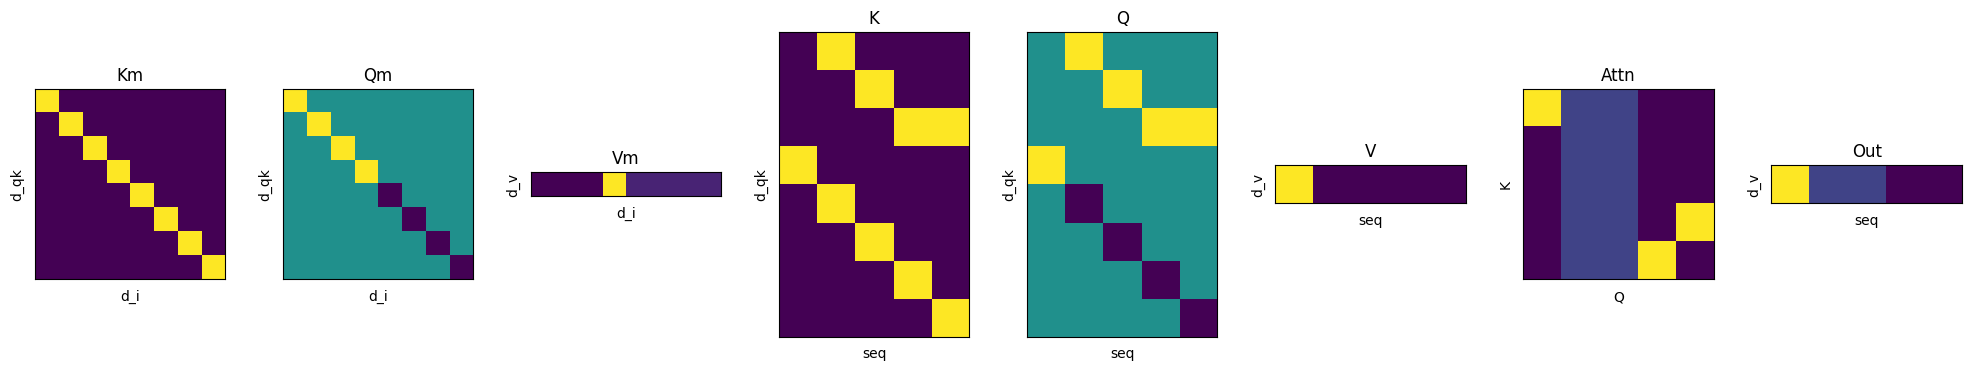

========================================    Learned    ========================================


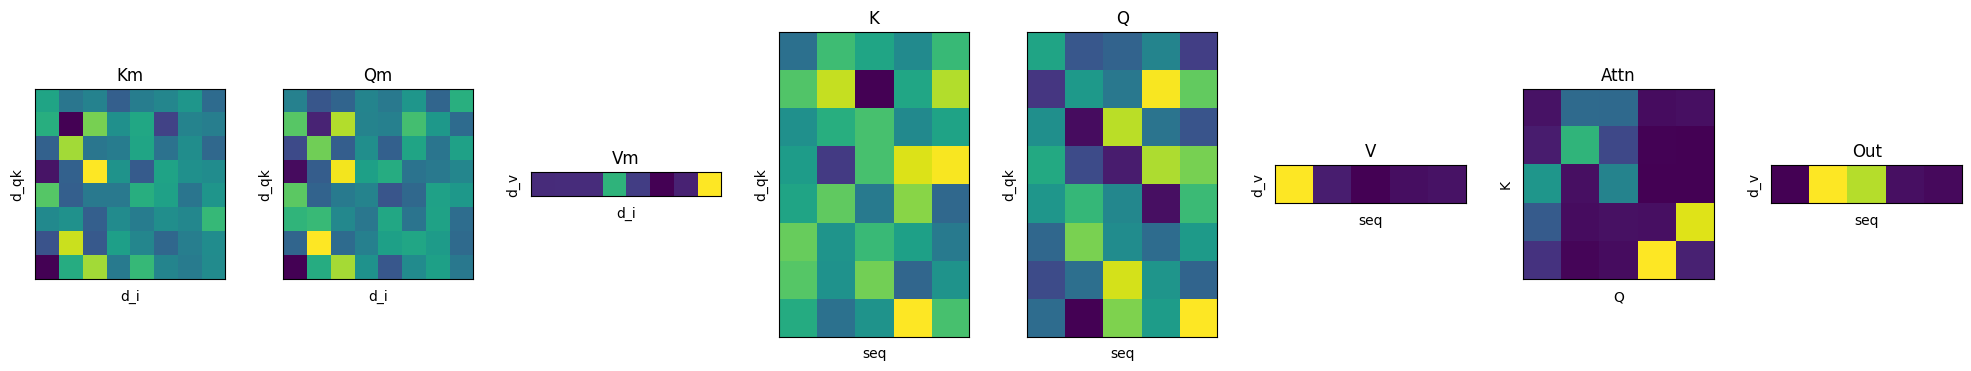

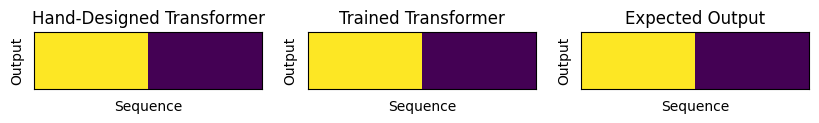

In [ ]:
# Compare the numpy and trained pytorch transformers
# Note that the pytorch transformer has a slightly harder task since it is being trained to output exactly 1 or -1, not just the sign.
def make_batch_unique(tokens=tokens, max_len=5):
    seq, target = generate_test_cases_unique(tokens, max_len=max_len)
    return torch.FloatTensor(seq), torch.FloatTensor(target)

pos_dim = pos.shape[1]
transformer_py, loss = train_loop(make_batch_unique, input_dim=len(A), qk_dim=Km.shape[1], v_dim=Vm.shape[1], pos_dim=pos_dim, max_seq_len=pos.shape[0], remove_cls=True)
seq = np.stack([CLS, A, B, C, C])
expected_out = np.stack([1, 1, -1, -1]).reshape(-1, 1)
out_npy, out_pyt = compare_transformers(np_transformer, transformer_py, seq)
out_npy = np.sign(out_npy[1:])
out_pyt = np.sign(out_pyt[1:])

# Since the CLS token is visualized above and is not part of the sequence, we remove it here.
# We also take the sign of the output to directly compare it to the expected output.
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(out_npy.T, vmin=-1, vmax=1)
plt.title('Hand-Designed Transformer')
plt.xticks([])
plt.yticks([])
plt.xlabel('Sequence')
plt.ylabel('Output')
plt.subplot(1, 3, 2)
plt.imshow(out_pyt.T, vmin=-1, vmax=1)
plt.title('Trained Transformer')
plt.xticks([])
plt.yticks([])
plt.xlabel('Sequence')
plt.ylabel('Output')
plt.subplot(1, 3, 3)
plt.imshow(expected_out.T, vmin=-1, vmax=1)
plt.title('Expected Output')
plt.xticks([])
plt.yticks([])
plt.xlabel('Sequence')
plt.ylabel('Output')
plt.show()
